    Processing mask 1/50
    Processing mask 11/50
    Processing mask 21/50
    Processing mask 31/50
    Processing mask 41/50


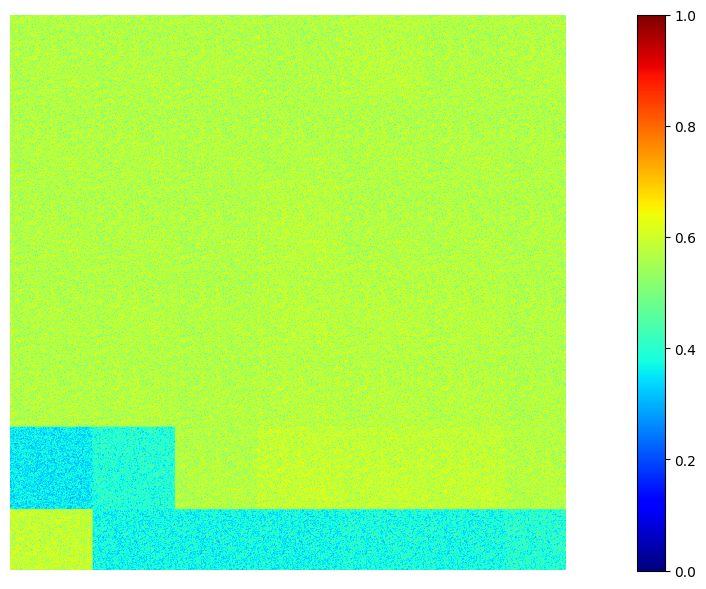

Processing completed.


<Figure size 640x480 with 0 Axes>

In [2]:
import cv2
import numpy as np
import pandas as pd
from patchify import patchify, unpatchify
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os

from preprocess import crop, padder, crop_to_coordinates
from helpers import f1

def generate_rise_masks(input_shape, n_masks=50, p1=0.5):
    """Generate random binary masks for RISE"""
    masks = []
    for _ in range(n_masks):
        mask = np.random.binomial(1, p1, size=input_shape[:2])
        masks.append(mask)
    return np.array(masks)

def apply_mask(image, mask):
    """Apply binary mask to image"""
    masked_image = image.copy()
    for c in range(image.shape[2]):
        masked_image[:, :, c] = masked_image[:, :, c] * mask
    return masked_image

def get_rise_saliency_lstm_batch(model, patches, n_masks=50, p1=0.5):
    """Generate RISE saliency maps for a batch of patches with LSTM UNet"""
    batch_size = len(patches)
    patch_shape = patches[0].shape
    
    # Prepare batch for LSTM UNet: (batch, time, height, width, channels)
    # Repeat each patch 15 times for time dimension
    patches_batch = np.array(patches)  # Shape: (batch, H, W, C)
    patches_batch = np.repeat(patches_batch[:, np.newaxis, :, :, :], 15, axis=1)  # Shape: (batch, 15, H, W, C)
    
    # Get baseline predictions for all patches
    baseline_preds = model.predict(patches_batch, verbose=0)
    
    # Initialize saliency maps for all patches
    saliency_maps = np.zeros((batch_size, patch_shape[0], patch_shape[1]))
    
    # Process each mask
    for mask_idx in range(n_masks):
        if mask_idx % 10 == 0:
            print(f"    Processing mask {mask_idx + 1}/{n_masks}")
            
        # Generate single mask for this iteration
        mask = np.random.binomial(1, p1, size=patch_shape[:2])
        
        # Apply mask to all patches
        masked_patches = []
        for patch in patches:
            masked_patch = apply_mask(patch, mask)
            masked_patches.append(masked_patch)
        
        # Create batch for masked patches
        masked_patches_batch = np.array(masked_patches)
        masked_patches_batch = np.repeat(masked_patches_batch[:, np.newaxis, :, :, :], 15, axis=1)
        
        # Get predictions for masked patches
        masked_preds = model.predict(masked_patches_batch, verbose=0)
        
        # Calculate differences for each patch
        for i in range(batch_size):
            pred_diff = np.mean(baseline_preds[i] - masked_preds[i])
            saliency_maps[i] += mask * pred_diff
    
    # Normalize all saliency maps
    saliency_maps = saliency_maps / n_masks
    for i in range(batch_size):
        smap = saliency_maps[i]
        if smap.max() > smap.min():
            saliency_maps[i] = (smap - smap.min()) / (smap.max() - smap.min())
    
    return saliency_maps

def overlay_saliency_on_image(img, saliency_map, alpha=0.7):
    """Overlay saliency map on image with stronger red visibility"""
    saliency_rgb = plt.cm.jet(saliency_map)[:, :, :3]
    overlay = saliency_rgb * alpha + img * (1 - alpha)
    return overlay

def pipeline_lstm(image_dir, kernel_size=5, patch_size=256, n_masks=50, p1=0.5):
    # Load LSTM UNet model
    model_path = "models/lstm_unet_run4.h5"  # Adjust path as needed
    model = load_model(model_path, custom_objects={"f1": f1})

    for file in os.listdir(image_dir):
        if file.endswith('28_05_15.png'):
            
            # Load and preprocess image
            img_path = os.path.join(image_dir, file)
            image = cv2.imread(img_path, 0)
            image_cropped, stats, centroids = crop(image, kernel_size=kernel_size)
            image_color = cv2.cvtColor(image_cropped, cv2.COLOR_GRAY2RGB)
            image_np = image_color / 255.0

            # Pad and patchify
            image_padded = padder(image_np, patch_size=patch_size)
            patches = patchify(image_padded, (patch_size, patch_size, 3), step=patch_size)
            expected_shape = (image_padded.shape[0] // patch_size, image_padded.shape[1] // patch_size)
            patches = patches.reshape(-1, patch_size, patch_size, 3)
            
            # Apply RISE to all patches in batch using LSTM-specific function
            saliency_maps = get_rise_saliency_lstm_batch(model, patches, n_masks=n_masks, p1=p1)
            
            # Generate overlay patches
            overlay_patches = []
            for i, patch in enumerate(patches):
                overlay_patch = overlay_saliency_on_image(patch, saliency_maps[i])
                overlay_patches.append(overlay_patch)
            
            # Reshape patches back to grid format using the expected_shape
            patches_grid = np.array(patches).reshape(
                expected_shape[0], expected_shape[1], 
                patch_size, patch_size, 3
            )
            
            saliency_patches_grid = np.array(saliency_maps).reshape(
                expected_shape[0], expected_shape[1], 
                patch_size, patch_size
            )
            
            overlay_patches_grid = np.array(overlay_patches).reshape(
                expected_shape[0], expected_shape[1], 
                patch_size, patch_size, 3
            )
            
            # Manual reconstruction instead of unpatchify to avoid dimension issues
            grid_h, grid_w = expected_shape[0], expected_shape[1]
            
            # Initialize full arrays
            full_image_reconstructed = np.zeros(image_padded.shape)
            full_saliency_reconstructed = np.zeros(image_padded.shape[:2])
            full_overlay_reconstructed = np.zeros(image_padded.shape)
            
            # Manually place each patch back
            for i in range(grid_h):
                for j in range(grid_w):
                    y_start = i * patch_size
                    y_end = y_start + patch_size
                    x_start = j * patch_size
                    x_end = x_start + patch_size
                    
                    # Place patches back
                    full_image_reconstructed[y_start:y_end, x_start:x_end] = patches_grid[i, j]
                    full_saliency_reconstructed[y_start:y_end, x_start:x_end] = saliency_patches_grid[i, j]
                    full_overlay_reconstructed[y_start:y_end, x_start:x_end] = overlay_patches_grid[i, j]
            
            # Crop back to original size (remove padding)
            original_h, original_w = image_np.shape[:2]
            full_image_final = full_image_reconstructed[:original_h, :original_w]
            full_saliency_final = full_saliency_reconstructed[:original_h, :original_w]
            full_overlay_final = full_overlay_reconstructed[:original_h, :original_w]
            
            # Plot the full reconstructed results
            fig, axs = plt.subplots(1, 1, figsize=(18, 6))
            
            # Saliency map
            im1 = axs.imshow(full_saliency_final, cmap='jet')
            axs.axis("off")
            plt.colorbar(im1, ax=axs, fraction=0.046, pad=0.04)

            plt.tight_layout()
            plt.show()
            plt.savefig('lstm_unet_xai.png')

    print("Processing completed.")

# Example usage
pipeline_lstm('data_v3_processed/xai', kernel_size=5, patch_size=256, n_masks=50, p1=0.8)